# Параллельные вычисления

__Автор задач: Блохин Н.В. (NVBlokhin@fa.ru)__

Материалы:
* Макрушин С.В. Лекция "Параллельные вычисления"
* https://docs.python.org/3/library/multiprocessing.html
    * https://docs.python.org/3/library/multiprocessing.html#multiprocessing.Process
    * https://docs.python.org/3/library/multiprocessing.html#multiprocessing.pool.Pool
    * https://docs.python.org/3/library/multiprocessing.html#multiprocessing.Queue
* https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html
* https://numpy.org/doc/stable/reference/generated/numpy.array_split.html
* https://nalepae.github.io/pandarallel/
    * https://github.com/nalepae/pandarallel/blob/master/docs/examples_windows.ipynb
    * https://github.com/nalepae/pandarallel/blob/master/docs/examples_mac_linux.ipynb

## Задачи для совместного разбора

In [1]:
!pip install pandarallel

  Created wheel for pandarallel: filename=pandarallel-1.6.3-py3-none-any.whl size=16450 sha256=ffe4b458323113bb3521612acaeb67b59fb1277fc0f5e39590c4f883340a5c06
  Stored in directory: c:\users\-\appdata\local\pip\cache\wheels\16\f5\91\d7efa7c4911ae1cf1aff825f902382eb69a1855f9987a7d17c
Successfully built pandarallel


1. Посчитайте, сколько раз встречается буква "a" в файлах ["xaa", "xab", "xac", "xad"]. 

In [5]:
import multiprocessing

files = [f"{name}.txt" for name in ["xaa", "xab", "xac", "xad"]]

In [6]:
from collections import Counter

def count_a(file):
    with open(file) as fp:
        text = fp.read().lower()
    res = Counter(text)['a']
    print(file, res)
    return res

In [7]:
%%time
[count_a(f) for f in files]

xaa.txt 2599627
xab.txt 2605911
xac.txt 2599868
xad.txt 1460452
Wall time: 5.47 s


[2599627, 2605911, 2599868, 1460452]

In [8]:
%%file count_a.py
from collections import Counter

def count_a(file):
    with open(file) as fp:
        text = fp.read().lower()
    res = Counter(text)['a']
    print(file, res)
    return res

Writing count_a.py


In [9]:
from count_a import count_a

In [18]:
%%time
with multiprocessing.Pool(processes=4) as pool:
    res = pool.map(count_a, files)
res

Wall time: 1.97 s


[2599627, 2605911, 2599868, 1460452]

In [196]:
%%file count_a_q.py
from collections import Counter

def count_a_q(file, queue):
    with open(file) as fp:
        text = fp.read().lower()
    res = Counter(text)['a']
    print(file, res) 
    queue.put(res)

Overwriting count_a_q.py


In [197]:
from count_a_q import count_a_q

In [201]:
%%time
ps = []
queue = multiprocessing.Queue()

for f in files:
    p = multiprocessing.Process(target=count_a_q, args=(f, queue))
    ps.append(p)
    p.start()

rs = []    
while len(rs) < 4:
    if not queue.empty():
        rs.append(queue.get())

for p in ps:
    p.join()
rs

Wall time: 1min 3s


[7965889, 7966626, 7971583, 7967126]

2. Выведите на экран слова из файла words_alpha, в которых есть две или более буквы "e" подряд.

In [1]:
import pandas as pd

words = (
    pd.read_csv("words_alpha.txt", header=None)[0]
    .dropna()
    .sample(frac=1, replace=True)
)

In [2]:
import re

def f(s):
    return bool(re.findall(r'e{2,}', s))

In [3]:
%%file f.py
import re

def f(s):
    return bool(re.findall(r'e{2,}', s))

Overwriting f.py


In [4]:
from f import f

In [5]:
from pandarallel import pandarallel
pandarallel.initialize()

INFO: Pandarallel will run on 6 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


In [8]:
%%time
words[words.map(f)]

Wall time: 1.7 s


103871           erminee
247432    preexpectation
247358     preestimating
129567          greenish
110889           feeless
               ...      
306019            streep
182297           meerkat
264724        reenforces
160740             jeeps
40399           breekums
Name: 0, Length: 7423, dtype: object

In [7]:
%%time
words[words.parallel_map(f)].size

Wall time: 1.34 s


7423

## Лабораторная работа 10

__При решении данных задач не подразумевается использования циклов или генераторов Python в ходе работы с пакетами `numpy` и `pandas`, если в задании не сказано обратного. Решения задач, в которых для обработки массивов `numpy` или структур `pandas` используются явные циклы (без согласования с преподавателем), могут быть признаны некорректными и не засчитаны.__

1\. В каждой строке файла `tag_nsteps.csv` хранится информация о тэге рецепта и количестве шагов в этом рецепте в следующем виде:

```
tags,n_steps
hungarian,2
european,6
occasion,4
pumpkin,4
................
```

Всего в исходном файле хранится чуть меньше, чем 71 млн, строк. Разбейте файл `tag_nsteps.csv` на несколько (например, 8) примерно одинаковых по объему файлов c названиями `tag_nsteps_*.csv`, где вместо символа `*` указан номер очередного файла. Каждый файл имеет структуру, аналогичную оригинальному файлу (включая заголовок).

__Важно__: здесь и далее вы не можете загружать в память весь исходный файл сразу. 

https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html взять специальный параметр 

In [22]:
import pandas as pd 
rows = pd.read_csv("tag_nsteps.csv", chunksize=8875000) 
for i, chuck in enumerate(rows): 
    chuck.to_csv('tag_nsteps_{}.csv'.format(i))

2\. Напишите функцию, которая принимает на вход название файла, созданного в результате решения задачи 1, считает для каждого тэга сумму по столбцу `n_steps` и количество строк c этим тэгом, и возвращает результат в виде словаря. Ожидаемый вид итогового словаря:

```
{
    '1-day-or-more': {'sum': 56616, 'count': 12752},
    '15-minutes-or-less': {'sum': 195413, 'count': 38898},
    '3-steps-or-less': {'sum': 187938, 'count': 39711},
    ....
}
```

Примените данную функцию к каждому файлу, полученному в задании 1, и соберите результат в виде списка словарей. Не используйте параллельных вычислений. 

Выведите на экран значение по ключу "30-minutes-or-less" для каждого из словарей.

In [2]:
def get_tag_sum_count_from_file(file: str) -> dict:
    tg = pd.read_csv(file)
    tg = tg.drop(['Unnamed: 0'], axis=1)
    summ = tg.groupby('tags')['n_steps'].sum()
    count = tg.groupby('tags').count()['n_steps']
    dict1 = pd.concat([summ, count], axis=1, keys = ['sum', 'count'])
    dict1 = dict1.to_dict('index')
    return dict1

In [3]:
get_tag_sum_count_from_file('tag_nsteps_0.csv')

{'1-day-or-more': {'sum': 56616, 'count': 12752},
 '15-minutes-or-less': {'sum': 195413, 'count': 38898},
 '3-steps-or-less': {'sum': 187938, 'count': 39711},
 '30-minutes-or-less': {'sum': 348943, 'count': 45605},
 '4-hours-or-less': {'sum': 429827, 'count': 42683},
 '5-ingredients-or-less': {'sum': 179724, 'count': 33842},
 '60-minutes-or-less': {'sum': 522209, 'count': 55224},
 'Throw the ultimate fiesta with this sopaipillas recipe from Food.com.': {'sum': 39985,
  'count': 11451},
 'a1-sauce': {'sum': 40025, 'count': 11357},
 'african': {'sum': 57174, 'count': 13138},
 'american': {'sum': 232336, 'count': 30755},
 'amish-mennonite': {'sum': 40700, 'count': 11419},
 'angolan': {'sum': 39530, 'count': 11285},
 'appetizers': {'sum': 150075, 'count': 24009},
 'apples': {'sum': 69464, 'count': 14320},
 'april-fools-day': {'sum': 39256, 'count': 11228},
 'argentine': {'sum': 40794, 'count': 11393},
 'artichoke': {'sum': 40371, 'count': 11546},
 'asian': {'sum': 127677, 'count': 19833},


## Применил данную функцию к каждому файлу

In [4]:
def get_tag_sum_count_from_file(file: str) -> dict:
    tg = pd.read_csv(file)
    tg = tg.drop(['Unnamed: 0'], axis=1)
    summ = tg.groupby('tags')['n_steps'].sum()
    count = tg.groupby('tags').count()['n_steps']
    dict1 = pd.concat([summ, count], axis=1, keys = ['sum', 'count'])
    dict1 = dict1.to_dict('index')
    return file, dict1

In [5]:
files = [f"tag_nsteps_{i}.csv" for i in ["0", "1", "2", "3", "4", "5", "6", "7"]]

In [6]:
%%time
dicc = [get_tag_sum_count_from_file(f) for f in files]
dicc

Wall time: 28.4 s


[('tag_nsteps_0.csv',
  {'1-day-or-more': {'sum': 56616, 'count': 12752},
   '15-minutes-or-less': {'sum': 195413, 'count': 38898},
   '3-steps-or-less': {'sum': 187938, 'count': 39711},
   '30-minutes-or-less': {'sum': 348943, 'count': 45605},
   '4-hours-or-less': {'sum': 429827, 'count': 42683},
   '5-ingredients-or-less': {'sum': 179724, 'count': 33842},
   '60-minutes-or-less': {'sum': 522209, 'count': 55224},
   'Throw the ultimate fiesta with this sopaipillas recipe from Food.com.': {'sum': 39985,
    'count': 11451},
   'a1-sauce': {'sum': 40025, 'count': 11357},
   'african': {'sum': 57174, 'count': 13138},
   'american': {'sum': 232336, 'count': 30755},
   'amish-mennonite': {'sum': 40700, 'count': 11419},
   'angolan': {'sum': 39530, 'count': 11285},
   'appetizers': {'sum': 150075, 'count': 24009},
   'apples': {'sum': 69464, 'count': 14320},
   'april-fools-day': {'sum': 39256, 'count': 11228},
   'argentine': {'sum': 40794, 'count': 11393},
   'artichoke': {'sum': 40371, 

## Вывел на экран значение по ключу "30-minutes-or-less" для каждого из словарей.

In [7]:
test = dict(dicc)
f = [test[f'tag_nsteps_{i}.csv']['30-minutes-or-less'] for i in ["0", "1", "2", "3", "4", "5", "6", "7"]]
f

[{'sum': 348943, 'count': 45605},
 {'sum': 350194, 'count': 46053},
 {'sum': 353624, 'count': 46295},
 {'sum': 347697, 'count': 45621},
 {'sum': 346528, 'count': 45650},
 {'sum': 350333, 'count': 46014},
 {'sum': 346536, 'count': 45814},
 {'sum': 339350, 'count': 44730}]

3\. Напишите функцию, которая объединяет результаты обработки отдельных файлов. Данная функция принимает на вход список словарей, каждый из которых является результатом вызова функции `get_tag_sum_count_from_file` для конкретного файла, и агрегирует эти словари. Не используйте параллельных вычислений.

Процедура агрегации словарей имеет следующий вид:
$$d_{agg}[k] = \{sum: \sum_{i=1}^{n}d_{i}[k][sum], count: \sum_{i=1}^{n}d_{i}[k][count]\}$$
где $d_1, d_2, ..., d_n$- результат вызова функции `get_tag_sum_count_from_file` для конкретных файлов.

Примените данную функцию к результату выполнения задания 2. Выведите на экран результат для тэга "30-minutes-or-less".

In [8]:
test = dict(dicc)
a1 = []
a2 = []
a3 = []
a4 = []
a5 = []
a6 = []
a7 = []
a8 = []
for j in test[f'tag_nsteps_1.csv']:
    a1.append(j)  
for j in test[f'tag_nsteps_1.csv']:
    a2.append(j) 
for j in test[f'tag_nsteps_1.csv']:
    a3.append(j) 
for j in test[f'tag_nsteps_1.csv']:
    a4.append(j) 
for j in test[f'tag_nsteps_1.csv']:
    a5.append(j) 
for j in test[f'tag_nsteps_1.csv']:
    a6.append(j) 
for j in test[f'tag_nsteps_1.csv']:
    a7.append(j) 
for j in test[f'tag_nsteps_1.csv']:
    a8.append(j) 
print(a1==a2==a3==a4==a5==a6==a7==a8)

True


## Проверив, что длины и значения названий тэгов во всех файлов равны, могу ориентироваться на тэги одного файла

In [9]:
def agg_results(tag_sum_count_list: list) -> dict:
    test = dict(tag_sum_count_list)
    final_dist = {}
    for j in test[list(test.keys())[0]].keys():
        a=[]
        for i in ["0", "1", "2", "3", "4", "5", "6", "7"]:
            a.append(test[f'tag_nsteps_{i}.csv'][j])
        resultdict = {}
        for dictionary in a: 
            for key in dictionary:   
                try:
                    resultdict[key] += dictionary[key] 

                except KeyError:                                    
                    resultdict[key] = dictionary[key]
        final_dist[j] = resultdict
    return final_dist

In [10]:
fn = agg_results(dicc)
fn

{'1-day-or-more': {'sum': 445183, 'count': 99994},
 '15-minutes-or-less': {'sum': 1547424, 'count': 310334},
 '3-steps-or-less': {'sum': 1491237, 'count': 315807},
 '30-minutes-or-less': {'sum': 2783205, 'count': 365782},
 '4-hours-or-less': {'sum': 3423888, 'count': 339507},
 '5-ingredients-or-less': {'sum': 1431950, 'count': 268658},
 '60-minutes-or-less': {'sum': 4161560, 'count': 441806},
 'Throw the ultimate fiesta with this sopaipillas recipe from Food.com.': {'sum': 319572,
  'count': 91099},
 'a1-sauce': {'sum': 322070, 'count': 91445},
 'african': {'sum': 459437, 'count': 105525},
 'american': {'sum': 1860381, 'count': 245764},
 'amish-mennonite': {'sum': 326639, 'count': 91688},
 'angolan': {'sum': 313213, 'count': 89884},
 'appetizers': {'sum': 1188876, 'count': 190801},
 'apples': {'sum': 556755, 'count': 114500},
 'april-fools-day': {'sum': 314896, 'count': 89701},
 'argentine': {'sum': 322047, 'count': 90095},
 'artichoke': {'sum': 319312, 'count': 91307},
 'asian': {'sum

In [11]:
fn['30-minutes-or-less']

{'sum': 2783205, 'count': 365782}

4\. Напишите функцию, которая считает среднее значение количества шагов для каждого тэга в словаре, имеющего вид, аналогичный словарям в задаче 2, и возвращает результат в виде словаря . Используйте решения задач 1-3, чтобы получить среднее значение количества шагов каждого тэга для всего датасета, имея результаты обработки частей датасета и результат их агрегации. Выведите на экран результат для тэга "30-minutes-or-less".

Определите, за какое время задача решается для всего датасета. При замере времени учитывайте время расчета статистики для каждого файла, агрегации результатов и, собственно, вычисления средного. Временем, затрачиваемым на процедуру разбиения исходного файла можно пренебречь.

In [12]:
%%time
def get_tag_sum_count_from_file(file: str) -> dict:
    tg = pd.read_csv(file)
    tg = tg.drop(['Unnamed: 0'], axis=1)
    summ = tg.groupby('tags')['n_steps'].mean()
    #count = tg.groupby('tags').count()['n_steps']
    dict1 = pd.concat([summ], axis=1, keys = ['mean'])
    dict1 = dict1.to_dict('index')
    return file, dict1

files = [f"tag_nsteps_{i}.csv" for i in ["0", "1", "2", "3", "4", "5", "6", "7"]]

dicc = [get_tag_sum_count_from_file(f) for f in files]

def get_tag_mean_n_steps(tag_sum_count: dict) -> dict:
    test = dict(tag_sum_count)
    final_dist = {}
    for j in test[list(test.keys())[0]].keys():
        a=[]
        for i in ["0", "1", "2", "3", "4", "5", "6", "7"]:
            a.append(test[f'tag_nsteps_{i}.csv'][j])
        resultdict = {}
        for dictionary in a: 
            for key in dictionary:   
                try:
                    resultdict[key] += dictionary[key] 
                except KeyError:                                    
                    resultdict[key] = dictionary[key]
        resultdict['mean'] =  resultdict['mean']/8   
        final_dist[j] = resultdict
    return final_dist
    
dicc1 = get_tag_mean_n_steps(dicc)
dicc1

Wall time: 21.6 s


{'1-day-or-more': {'mean': 4.451956792762154},
 '15-minutes-or-less': {'mean': 4.986285606638711},
 '3-steps-or-less': {'mean': 4.722149451652546},
 '30-minutes-or-less': {'mean': 7.608835942144001},
 '4-hours-or-less': {'mean': 10.084905631266077},
 '5-ingredients-or-less': {'mean': 5.33007296736754},
 '60-minutes-or-less': {'mean': 9.419472541402909},
 'Throw the ultimate fiesta with this sopaipillas recipe from Food.com.': {'mean': 3.5078070838328346},
 'a1-sauce': {'mean': 3.521876974830641},
 'african': {'mean': 4.3537158845022494},
 'american': {'mean': 7.569736169619724},
 'amish-mennonite': {'mean': 3.562465910620256},
 'angolan': {'mean': 3.4846504603829342},
 'appetizers': {'mean': 6.230983893465499},
 'apples': {'mean': 4.862625694321018},
 'april-fools-day': {'mean': 3.5104706181806185},
 'argentine': {'mean': 3.5745739453981233},
 'artichoke': {'mean': 3.49719967307655},
 'asian': {'mean': 6.454093586496725},
 'asparagus': {'mean': 4.071544474367097},
 'australian': {'mean

In [13]:
dicc1['30-minutes-or-less']

{'mean': 7.608835942144001}

5\. Повторите решение задачи 4, распараллелив вызовы функции `get_tag_sum_count_from_file` для различных файлов с помощью `multiprocessing.Pool`. Для обработки каждого файла создайте свой собственный процесс. Выведите на экран результат для тэга "30-minutes-or-less". Определите, за какое время задача решается для всех файлов. При замере времени учитывайте время расчета статистики для каждого файла, агрегации результатов и, собственно, вычисления средного. Временем, затрачиваемым на процедуру разбиения исходного файла можно пренебречь.

In [14]:
import multiprocessing

In [15]:
%%file mean_a.py
import pandas as pd
def get_tag_sum_count_from_file(file: str) -> dict:
    tg = pd.read_csv(file)
    tg = tg.drop(['Unnamed: 0'], axis=1)
    summ = tg.groupby('tags')['n_steps'].mean()
    #count = tg.groupby('tags').count()['n_steps']
    dict1 = pd.concat([summ], axis=1, keys = ['mean'])
    dict1 = dict1.to_dict('index')
    return file, dict1

Overwriting mean_a.py


In [16]:
%%time
files = [f"tag_nsteps_{i}.csv" for i in ["0", "1", "2", "3", "4", "5", "6", "7"]]
from mean_a import get_tag_sum_count_from_file
with multiprocessing.Pool(processes=8) as pool:
    res = pool.map(get_tag_sum_count_from_file, files)

def get_tag_mean_n_steps(tag_sum_count: dict) -> dict:
    test = dict(tag_sum_count)
    final_dist = {}
    for j in test[list(test.keys())[0]].keys():
        a=[]
        for i in ["0", "1", "2", "3", "4", "5", "6", "7"]:
            a.append(test[f'tag_nsteps_{i}.csv'][j])
        resultdict = {}
        for dictionary in a: 
            for key in dictionary:   
                try:
                    resultdict[key] += dictionary[key] 
                except KeyError:                                    
                    resultdict[key] = dictionary[key]
        resultdict['mean'] =  resultdict['mean']/8   
        final_dist[j] = resultdict
    return final_dist
dicc1 = get_tag_mean_n_steps(res)
dicc1

Wall time: 6.69 s


{'1-day-or-more': {'mean': 4.451956792762154},
 '15-minutes-or-less': {'mean': 4.986285606638711},
 '3-steps-or-less': {'mean': 4.722149451652546},
 '30-minutes-or-less': {'mean': 7.608835942144001},
 '4-hours-or-less': {'mean': 10.084905631266077},
 '5-ingredients-or-less': {'mean': 5.33007296736754},
 '60-minutes-or-less': {'mean': 9.419472541402909},
 'Throw the ultimate fiesta with this sopaipillas recipe from Food.com.': {'mean': 3.5078070838328346},
 'a1-sauce': {'mean': 3.521876974830641},
 'african': {'mean': 4.3537158845022494},
 'american': {'mean': 7.569736169619724},
 'amish-mennonite': {'mean': 3.562465910620256},
 'angolan': {'mean': 3.4846504603829342},
 'appetizers': {'mean': 6.230983893465499},
 'apples': {'mean': 4.862625694321018},
 'april-fools-day': {'mean': 3.5104706181806185},
 'argentine': {'mean': 3.5745739453981233},
 'artichoke': {'mean': 3.49719967307655},
 'asian': {'mean': 6.454093586496725},
 'asparagus': {'mean': 4.071544474367097},
 'australian': {'mean

In [17]:
dicc1['30-minutes-or-less']

{'mean': 7.608835942144001}

6\. Повторите решение задачи 4, распараллелив вычисления функции `get_tag_sum_count_from_file` для различных файлов с помощью `multiprocessing.Process`. Для обработки каждого файла создайте свой собственный процесс. Для обмена данными между процессами используйте `multiprocessing.Queue`.

Выведите на экран результат для тэга "30-minutes-or-less". Определите, за какое время задача решается для всех файлов. При замере времени учитывайте время расчета статистики для каждого файла, агрегации результатов и, собственно, вычисления средного. Временем, затрачиваемым на процедуру разбиения исходного файла можно пренебречь.

In [18]:
%%file mean_a1.py
import pandas as pd
def get_tag_sum_count_from_file(file: str, queue) -> dict:
    tg = pd.read_csv(file)
    tg = tg.drop(['Unnamed: 0'], axis=1)
    summ = tg.groupby('tags')['n_steps'].mean()
    #count = tg.groupby('tags').count()['n_steps']
    dict1 = pd.concat([summ], axis=1, keys = ['mean'])
    dict1 = dict1.to_dict('index')
    queue.put(dict1)

Overwriting mean_a1.py


In [19]:
from mean_a1 import get_tag_sum_count_from_file

In [20]:
files = [f"tag_nsteps_{i}.csv" for i in ["0", "1", "2", "3", "4", "5", "6", "7"]]

In [21]:
import numpy as np

In [22]:
%%time
ps = []
queue = multiprocessing.Queue()

for f in files:
    p = multiprocessing.Process(target=get_tag_sum_count_from_file, args=(f, queue))
    ps.append(p)
    p.start()

rs = []    
while len(rs) < len(files):
    if not queue.empty():
        rs.append(queue.get())

for p in ps:
    p.join()
    
def get_tag_mean_n_steps(tag_sum_count: dict) -> dict:
    final_dist = {}
    for j in tag_sum_count[0].keys():
        a=[]
        for i in [0,1,2,3,4,5,6,7]:
            a.append(tag_sum_count[i][j])
            resultdict = {}
        for dictionary in a: 
            for key in dictionary:   
                try:
                    resultdict[key] += dictionary[key] 
                except KeyError:                                    
                    resultdict[key] = dictionary[key]
        resultdict['mean'] =  resultdict['mean']/8   
        final_dist[j] = resultdict
    return final_dist
    
dicc1 = get_tag_mean_n_steps(rs)
dicc1

Wall time: 6.87 s


{'1-day-or-more': {'mean': 4.451956792762154},
 '15-minutes-or-less': {'mean': 4.986285606638711},
 '3-steps-or-less': {'mean': 4.722149451652546},
 '30-minutes-or-less': {'mean': 7.608835942144002},
 '4-hours-or-less': {'mean': 10.084905631266077},
 '5-ingredients-or-less': {'mean': 5.330072967367539},
 '60-minutes-or-less': {'mean': 9.419472541402909},
 'Throw the ultimate fiesta with this sopaipillas recipe from Food.com.': {'mean': 3.507807083832835},
 'a1-sauce': {'mean': 3.521876974830641},
 'african': {'mean': 4.3537158845022494},
 'american': {'mean': 7.569736169619725},
 'amish-mennonite': {'mean': 3.5624659106202556},
 'angolan': {'mean': 3.484650460382934},
 'appetizers': {'mean': 6.230983893465499},
 'apples': {'mean': 4.862625694321018},
 'april-fools-day': {'mean': 3.5104706181806176},
 'argentine': {'mean': 3.574573945398124},
 'artichoke': {'mean': 3.4971996730765498},
 'asian': {'mean': 6.454093586496724},
 'asparagus': {'mean': 4.071544474367097},
 'australian': {'mea

In [23]:
dicc1['30-minutes-or-less']

{'mean': 7.608835942144002}

7\. Исследуйте, как влияет количество запущенных одновременно процессов на скорость решения задачи. Узнайте количество ядер вашего процессора $K$. Повторите решение задачи 1, разбив исходный файл на $\frac{K}{2}$, $K$ и $2K$ фрагментов. Для каждого из разбиений повторите решение задачи 5. Визуализируйте зависимость времени выполнения кода от количества файлов в разбиении. Сделайте вывод в виде текстового комментария.

## K = 6

In [147]:
import pandas as pd 
rows = pd.read_csv("tag_nsteps.csv", chunksize=23666666) 
for i, chuck in enumerate(rows): 
    chuck.to_csv('tag_nsteps_k_2_{}.csv'.format(i))

In [150]:
import pandas as pd 
rows = pd.read_csv("tag_nsteps.csv", chunksize=11833333) 
for i, chuck in enumerate(rows): 
    chuck.to_csv('tag_nsteps_k_{}.csv'.format(i))

In [153]:
import pandas as pd 
rows = pd.read_csv("tag_nsteps.csv", chunksize=5916666) 
for i, chuck in enumerate(rows): 
    chuck.to_csv('tag_nsteps_2k_{}.csv'.format(i))

In [24]:
import time
tic = time.perf_counter()

files = [f"tag_nsteps_k_2_{i}.csv" for i in ["0", "1", "2"]]
from mean_a import get_tag_sum_count_from_file
with multiprocessing.Pool(processes=3) as pool:
    res = pool.map(get_tag_sum_count_from_file, files)

def get_tag_mean_n_steps(tag_sum_count: dict) -> dict:
    test = dict(tag_sum_count)
    final_dist = {}
    for j in test[list(test.keys())[0]].keys():
        a=[]
        for i in ["0", "1", "2"]:
            a.append(test[f'tag_nsteps_k_2_{i}.csv'][j])
        resultdict = {}
        for dictionary in a: 
            for key in dictionary:   
                try:
                    resultdict[key] += dictionary[key] 
                except KeyError:                                    
                    resultdict[key] = dictionary[key]
        resultdict['mean'] =  resultdict['mean']/3   
        final_dist[j] = resultdict
    return final_dist
dicc1 = get_tag_mean_n_steps(res)
print(dicc1)
toc = time.perf_counter()
timee = toc-tic
timee

{'1-day-or-more': {'mean': 4.452034844145126}, '15-minutes-or-less': {'mean': 4.986345873927481}, '3-steps-or-less': {'mean': 4.722094086038386}, '30-minutes-or-less': {'mean': 7.6088115757880495}, '4-hours-or-less': {'mean': 10.084995076384265}, '5-ingredients-or-less': {'mean': 5.329991301216627}, '60-minutes-or-less': {'mean': 9.419532754841248}, 'Throw the ultimate fiesta with this sopaipillas recipe from Food.com.': {'mean': 3.5079161800157306}, 'a1-sauce': {'mean': 3.5220161209352576}, 'african': {'mean': 4.353868678750751}, 'american': {'mean': 7.569833555560417}, 'amish-mennonite': {'mean': 3.5624640909945953}, 'angolan': {'mean': 3.4846418317721928}, 'appetizers': {'mean': 6.231004807315635}, 'apples': {'mean': 4.862588355527664}, 'april-fools-day': {'mean': 3.510466034151331}, 'argentine': {'mean': 3.5745698984819456}, 'artichoke': {'mean': 3.4971517032347452}, 'asian': {'mean': 6.4542460854465125}, 'asparagus': {'mean': 4.071565659277301}, 'australian': {'mean': 4.2180732690

9.569426300000003

In [25]:
tic = time.perf_counter()
files = [f"tag_nsteps_k_{i}.csv" for i in ["0", "1", "2", "3", "4", "5"]]
from mean_a import get_tag_sum_count_from_file
with multiprocessing.Pool(processes=6) as pool:
    res = pool.map(get_tag_sum_count_from_file, files)

def get_tag_mean_n_steps(tag_sum_count: dict) -> dict:
    test = dict(tag_sum_count)
    final_dist = {}
    for j in test[list(test.keys())[0]].keys():
        a=[]
        for i in ["0", "1", "2", "3", "4", "5"]:
            a.append(test[f'tag_nsteps_k_{i}.csv'][j])
        resultdict = {}
        for dictionary in a: 
            for key in dictionary:   
                try:
                    resultdict[key] += dictionary[key] 
                except KeyError:                                    
                    resultdict[key] = dictionary[key]
        resultdict['mean'] =  resultdict['mean']/6   
        final_dist[j] = resultdict
    return final_dist
dicc2 = get_tag_mean_n_steps(res)
print(dicc2)
toc = time.perf_counter()
timee2 = toc - tic
timee2

{'1-day-or-more': {'mean': 4.451985282480451}, '15-minutes-or-less': {'mean': 4.98631974030743}, '3-steps-or-less': {'mean': 4.722131608961426}, '30-minutes-or-less': {'mean': 7.608804606393477}, '4-hours-or-less': {'mean': 10.084921947475962}, '5-ingredients-or-less': {'mean': 5.330061544759539}, '60-minutes-or-less': {'mean': 9.419530874707533}, 'Throw the ultimate fiesta with this sopaipillas recipe from Food.com.': {'mean': 3.5078499187655634}, 'a1-sauce': {'mean': 3.5219876413109077}, 'african': {'mean': 4.3537941272192695}, 'american': {'mean': 7.569869861207942}, 'amish-mennonite': {'mean': 3.5624537091913755}, 'angolan': {'mean': 3.4846499089569973}, 'appetizers': {'mean': 6.230963214999949}, 'apples': {'mean': 4.862587670700873}, 'april-fools-day': {'mean': 3.510472672413785}, 'argentine': {'mean': 3.5745545510358205}, 'artichoke': {'mean': 3.4971878184875322}, 'asian': {'mean': 6.454004993724965}, 'asparagus': {'mean': 4.0714855456873185}, 'australian': {'mean': 4.21791633580

7.150598700000003

In [26]:
tic = time.perf_counter()
files = [f"tag_nsteps_2k_{i}.csv" for i in ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11"]]
from mean_a import get_tag_sum_count_from_file
with multiprocessing.Pool(processes=12) as pool:
    res = pool.map(get_tag_sum_count_from_file, files)

def get_tag_mean_n_steps(tag_sum_count: dict) -> dict:
    test = dict(tag_sum_count)
    final_dist = {}
    for j in test[list(test.keys())[0]].keys():
        a=[]
        for i in ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11"]:
            a.append(test[f'tag_nsteps_2k_{i}.csv'][j])
        resultdict = {}
        for dictionary in a: 
            for key in dictionary:   
                try:
                    resultdict[key] += dictionary[key] 
                except KeyError:                                    
                    resultdict[key] = dictionary[key]
        resultdict['mean'] =  resultdict['mean']/12   
        final_dist[j] = resultdict
    return final_dist
dicc3 = get_tag_mean_n_steps(res)
print(dicc3)
toc = time.perf_counter()
timee3 = toc - tic
timee3

{'1-day-or-more': {'mean': 4.451797938201543}, '15-minutes-or-less': {'mean': 4.986331829594007}, '3-steps-or-less': {'mean': 4.722128292485046}, '30-minutes-or-less': {'mean': 7.608775731838668}, '4-hours-or-less': {'mean': 10.084963473296272}, '5-ingredients-or-less': {'mean': 5.329890711520925}, '60-minutes-or-less': {'mean': 9.419594658743739}, 'Throw the ultimate fiesta with this sopaipillas recipe from Food.com.': {'mean': 3.5078746082979637}, 'a1-sauce': {'mean': 3.522040343605458}, 'african': {'mean': 4.3538405207158695}, 'american': {'mean': 7.569809998460667}, 'amish-mennonite': {'mean': 3.5623985533727667}, 'angolan': {'mean': 3.484598777284633}, 'appetizers': {'mean': 6.231005884829664}, 'apples': {'mean': 4.862772097856193}, 'april-fools-day': {'mean': 3.5105284140430366}, 'argentine': {'mean': 3.574616799097347}, 'artichoke': {'mean': 3.497203327034294}, 'asian': {'mean': 6.454130509888308}, 'asparagus': {'mean': 4.071581745528276}, 'australian': {'mean': 4.21791533304382

7.252348600000005

In [27]:
import matplotlib.pyplot as plt

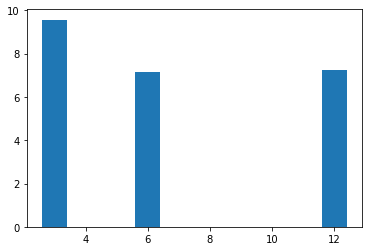

In [28]:
timm = [timee, timee2, timee3]
parts = [3, 6, 12]
plt.bar(parts,timm)
plt.show()

## Видно, что при разделении файла на большие подфайлы, функция работает дольше, чем при маленьких подфайлах


8\. Напишите функцию `parallel_map`, которая принимает на вход серию `s` `pd.Series` и функцию одного аргумента `f` и поэлементно применяет эту функцию к серии, распараллелив вычисления при помощи пакета `multiprocessing`. Логика работы функции `parallel_map` должна включать следующие действия:
* разбиение исходной серии на $K$ частей, где $K$ - количество ядер вашего процессора;
* параллельное применение функции `f` к каждой части при помощи метода _серии_ `map` при помощи нескольких подпроцессов;
* объединение результатов работы подпроцессов в одну серию. 

https://numpy.org/doc/stable/reference/generated/numpy.array_split.html

In [29]:
import numpy as np

In [30]:
%%file f.py
import re
def f(tag: str) -> bool:
    return bool(re.findall(r'\d+-[a-zA-z]+-or-less', tag))

Overwriting f.py


In [31]:
from f import f

In [32]:
def parallel_map(s: pd.Series, f: callable) -> pd.Series:
    res = []
    s = np.array(s)
    s = np.array_split(s, 6)
    s = list(map(lambda x: list(map(str, x)), s))
    with multiprocessing.Pool(processes=6) as pool:
        for i in range(len(s)):
            res.append(pool.map(f, s[i]))
    res = np.concatenate((res[0],res[1],res[2],res[3],res[4],res[5]),axis=None)
    ser = pd.Series(res)
    return ser

In [33]:
tg = pd.read_csv('tag_nsteps_0.csv')

In [34]:
%%time
parallel_map(tg['tags'], f).sum()

Wall time: 2.82 s


255963

9\. Напишите функцию `f`, которая принимает на вход тэг и проверяет, удовлетворяет ли тэг следующему шаблону: `[любое число]-[любое слово]-or-less`. Возьмите любой фрагмент файла, полученный в задании 1, примените функцию `f` при помощи `parallel_map` к столбцу `tags` и посчитайте количество тэгов, подходящих под этот шаблон. Решите ту же задачу, воспользовавшись методом _серий_ `map`. Сравните время и результат выполнения двух решений.

In [35]:
%%file f.py
import re
def f(tag: str) -> bool:
    return bool(re.findall(r'\d+-[a-zA-z]+-or-less', tag))

Overwriting f.py


In [36]:
from f import f

In [37]:
def parallel_map(s: pd.Series, f: callable) -> pd.Series:
    res = []
    s = np.array(s)
    s = np.array_split(s, 6)
    s = list(map(lambda x: list(map(str, x)), s))
    with multiprocessing.Pool(processes=6) as pool:
        for i in range(len(s)):
            res.append(pool.map(f, s[i]))
    res = np.concatenate((res[0],res[1],res[2],res[3],res[4],res[5]),axis=None)
    ser = pd.Series(res)
    return ser

In [38]:
tg = pd.read_csv('tag_nsteps_0.csv')

In [39]:
%%time
parallel_map(tg['tags'], f).sum()

Wall time: 2.84 s


255963

## Series.map

In [40]:
%%time
s = np.array(tg['tags'])
s = list(map(str, s))
s = pd.Series(s)
s.map(f).sum()

Wall time: 7.59 s


255963

10\. Используя пакет `pandarallel`, примените функцию `f` из задания 9 к столбцу `tags` таблицы, с которой вы работали этом задании. Посчитайте количество тэгов, подходящих под описанный шаблон. Измерьте время выполнения кода. Выведите на экран полученный результат.

In [41]:
from pandarallel import pandarallel
pandarallel.initialize()

INFO: Pandarallel will run on 6 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


In [42]:
import numpy as np
import pandas as pd

In [43]:
%%time
s = np.array(tg['tags'])
s = list(map(str, s))
s = pd.Series(s)
s[s.parallel_map(f)].size

Wall time: 3.66 s


255963